In [1]:
def derivative(f,a,method='central',h=0.01):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula

    Returns
    -------
    float
        Difference formula:
            central: f(a+h) - f(a-h))/2h
            forward: f(a+h) - f(a))/h
            backward: f(a) - f(a-h))/h            
    '''
    if method == 'central':
        return (f(a + h) - f(a - h))/(2*h)
    elif method == 'forward':
        return (f(a + h) - f(a))/h
    elif method == 'backward':
        return (f(a) - f(a - h))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")

In [2]:
import numpy as np
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

In [3]:
def gen_curve():

    dim = 3
    steps = 50
    delta_t = 0.1

    l1 = 100
    n = 60
    it = np.linspace(0, l1, n)
    v = np.array((-1, 0, 0))
    vert_sect = np.outer(it, v)
 
    n = 40
    theta = np.linspace(np.pi, 5/4 * np.pi, n)
    r = 50

    tmp = np.transpose(np.array([np.sin(theta)*r, np.cos(theta)*r, 0 * theta]))
    shift = -1 * np.array([np.sin(theta[0])*r, np.cos(theta[0])*r, 0]) + vert_sect[-1, :]
    bend_sect = (tmp 
            + np.tile(shift, n).reshape((n, 3))
            )[1:, :]

    n = 70
    #slope = np.array([-1/np.sqrt(3), 1/np.sqrt(3), 1/np.sqrt(3)])
    slope = bend_sect[-1, :] - bend_sect[-2, :]
    slpe = slope / np.sqrt(np.sum(slope**2))
    tang_sect = np.outer(np.linspace(0, 100, n), slope)
    tang_sect = (tang_sect + bend_sect[-1, :])[1:, :]
    
    gamma = np.concatenate([vert_sect, bend_sect, tang_sect]) 
    return gamma

In [4]:
gamma = gen_curve()

In [5]:
df = pd.DataFrame(gamma, columns=['z', 'x', 'y'])

fig = px.scatter_3d(df, x='x', y='y', z='z')
#fig.write_html('tops_3D'+".html")
fig.show() 

In [6]:
def dist_curve(gamma, x):
    
    return np.sqrt(np.nanmin(np.sum((gamma - x)**2, axis=1)))

In [7]:
dist_curve(gamma, np.array([-50, 2, 1]))

2.3912725544700173

In [8]:
def gamma_tangent(gamma):
    
    T_gam = np.empty(gamma.shape) * np.nan
    T_gam[1:, :] = (gamma[1:, :]-gamma[:-1, :])
    T_gam[1:-1, :] = np.divide(
                    T_gam[1:-1, :],
                    np.sqrt(np.sum(T_gam[1:-1, :]**2, axis=1)).reshape((-1, 1))
                    )
    return T_gam

In [9]:
def ortho_vects(t):

    if np.isnan(t).any():
        return np.empty((3, 3)) * np.nan
    mat = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    thresh = 1e-5
    u_1 = t / np.sqrt(np.sum(t**2))
    
    drop_inds = []
    for i, v in enumerate(mat):
        a = np.dot(v, u_1)
        if (a > 1 - thresh) or (a < -1 + thresh):
            drop_inds.append(i)
    
    inds = [x for x in [0, 1, 2] if x not in drop_inds]
    v_2 = mat[inds[0]]
    v_3 = mat[inds[1]]
    
    u_2 = (v_2 - np.dot(u_1, v_2) * u_1)
    u_2 = u_2/np.sqrt(np.dot(u_2, u_2))
    
    u_3 = v_3 - np.dot(u_1, v_3) * u_1 - np.dot(u_2, v_3) * u_2
    u_3n = np.sqrt(np.dot(u_3, u_3))
    if u_3n < thresh:
        v_3 = mat[inds[2]]
        u_3 = v_3 - np.dot(u_1, v_3) * u_1 - np.dot(u_2, v_3) * u_2
        u_3n = np.sqrt(np.dot(u_3, u_3))
    u_3 = u_3/u_3n
    
    return np.array([u_2, u_3, u_1])

def gamma_ortho_vects(T_gam):
    
    return np.apply_along_axis(ortho_vects, 1, T_gam)

In [10]:
V = gamma_ortho_vects(gamma_tangent(gamma))

In [11]:
def generate_tubular_boundary(gamma, V, r, h=0.05, dtheta=0.1):
    
    theta = np.arange(0, 2*np.pi, dtheta)
    print('theta shape', theta.shape)
    print('gamma shape', gamma.shape)
    boundary = np.empty((gamma.shape[0], theta.shape[0]))
    T_gam = gamma_tangent(gamma)
    
    g = lambda th, u_1, u_2: np.tensordot(np.sin(th), u_1, axes=0) * r + np.tensordot(np.cos(th), u_2, axes=0) * r
    boundary = gamma + g(theta, V[:, 0], V[:, 1])
    return boundary

In [12]:
boundary = generate_tubular_boundary(gamma, V, 5)

theta shape (63,)
gamma shape (168, 3)


In [13]:
boundary.shape

(63, 168, 3)

In [14]:
def boundary_tan_vect(boundary):
    '''
        in general find nearest neighbors
        for building tangent plane
    '''
    tan_vects = np.ones((boundary.shape[0], boundary.shape[1], 3, 3)) * np.nan
    shp = boundary.shape
    if len(boundary.shape)==3:
        tan_vects[1:, :, 0, :] = boundary[1:, :, :] - boundary[:-1, :, :]
        tan_vects[0, :, 0, :] = boundary[1, :, :] - boundary[0, :, :]
        tan_vects[:, 1:, 1, :] = boundary[:, 1:, :] - boundary[:, :-1, :]
        tan_vects[:, 0, 1, :] = boundary[:, 1, :] - boundary[:, 0, :]
        tan_vects[: , :, 0, :] = np.divide(tan_vects[:, :, 0, :],
                                np.sqrt(np.sum(tan_vects[:, :, 0, :]**2, axis=2)).reshape((shp[0], shp[1], 1))
                                )
        tan_vects[:, :, 1, :] = (tan_vects[:, :, 1, :] 
                                - np.sum(tan_vects[:, :, 0, :] * tan_vects[:, :, 1, :], axis=2).reshape((shp[0], shp[1], 1)) 
                                * tan_vects[:, :, 0, :] 
                                )
        tan_vects[:, :, 1, :] = np.divide(tan_vects[:, :, 1, :],
                                np.sqrt(np.sum(tan_vects[:, :, 1, :]**2, axis=2)).reshape((shp[0], shp[1], 1))
                                )
        tan_vects[:, :, 2, :] = -np.cross(tan_vects[:, :, 0, :], tan_vects[:, :, 1, :])
    return tan_vects

In [15]:
tan_boundary = boundary_tan_vect(boundary)

In [16]:
import sys
np.set_printoptions(threshold=sys.maxsize)

In [17]:
tan_boundary.shape

(63, 168, 3, 3)

In [18]:
df = pd.DataFrame(boundary.reshape((-1, 3)), columns=['z', 'x', 'y'])

#fig = go.Figure(data=go.Isosurface(x=df['x'], y=df['y'], z=df['z'], value=[1 for i in range(len(df))], surface_fill=0.5),
fig = px.scatter_3d(
        df, x='x', y='y', z='z',
        width=1024,
        height=1024,
        size=[0.0001 for i in range(len(df))], 
        color=['rgb(0,0,1)' for i in range(len(df))]
               )
fig.update_layout(
    scene = dict(
        xaxis={'title':'x.name', 'range': [-100, 100]},
        yaxis={'title':'y.name', 'range': [-100, 100]},
        zaxis={'title':'z.name', 'range': [0, -200]},
        aspectmode='cube'))

fig.show() 

In [19]:
bdry = boundary.reshape((-1, 3))
tbdry = tan_boundary.reshape((-1, 3, 3))
print(bdry.shape, tbdry.shape)


(10584, 3) (10584, 3, 3)


ind = 0

fig = go.Figure(data=go.Cone(x=bdry[:, 1], y=bdry[:, 2], z=bdry[:, 0], 
                             u=tbdry[:, ind, 1], v=tbdry[:, ind, 2], w=tbdry[:, ind, 0]),
                               )

#fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))
fig.update_layout(
    scene = dict(
        xaxis={'title':'x.name', 'range': [-100, 100]},
        yaxis={'title':'y.name', 'range': [-100, 100]},
        zaxis={'title':'z.name', 'range': [0, -200]},
        aspectmode='cube'),
        width=1024,
        height=1024
        )


fig.show()

ind = 1

fig = go.Figure(data=go.Cone(x=bdry[:, 1], y=bdry[:, 2], z=bdry[:, 0], 
                             u=tbdry[:, ind, 1], v=tbdry[:, ind, 2], w=tbdry[:, ind, 0]),
                               )

#fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))
fig.update_layout(
    scene = dict(
        xaxis={'title':'x.name', 'range': [-100, 100]},
        yaxis={'title':'y.name', 'range': [-100, 100]},
        zaxis={'title':'z.name', 'range': [0, -200]},
        aspectmode='cube'),
        width=1024,
        height=1024
        )


fig.show()

ind = 2

fig = go.Figure(data=go.Cone(x=bdry[:, 1], y=bdry[:, 2], z=bdry[:, 0], 
                             u=tbdry[:, ind, 1], v=tbdry[:, ind, 2], w=tbdry[:, ind, 0]),
                               )

#fig.update_layout(scene_camera_eye=dict(x=-0.76, y=1.8, z=0.92))
fig.update_layout(
    scene = dict(
        xaxis={'title':'x.name', 'range': [-100, 100]},
        yaxis={'title':'y.name', 'range': [-100, 100]},
        zaxis={'title':'z.name', 'range': [0, -200]},
        aspectmode='cube'),
        width=1024,
        height=1024
        )


fig.show()

In [20]:
class Particle():
    
    def __init__(self, q_0=np.zeros(3), p_0=np.zeros(3)):
        
        self.t_max = 100000
        self.q = q_0
        self.p = p_0
        self.path = np.zeros((self.t_max, 2, 3))
        self.path[0, 0, :] = q_0
        self.path[0, 1, :] = p_0 
        self.t = 0
        self.contact = np.zeros(self.t_max)
        
    def __repr__(self):
        
        return f"({self.q}, {self.p})"

In [21]:
def dist_boundary(boundary, q):
    
    return np.sqrt(np.nanmin(np.sum((boundary - q)**2, axis=2)))

def reactive_force(boundary, tan_boundary, x):
    
    q = x.q
    epsilon = 1
    F = np.zeros(3)
    d = dist_boundary(boundary, q)
    x.contact[x.t] = d
    if d < epsilon:
        tmp = np.sum((boundary-q)**2, axis=2)
        tmp[np.where(np.isnan(tmp))] = np.inf
        i = np.unravel_index(np.argmin(tmp.ravel()), tmp.shape)
        n = tan_boundary[i[0], i[1], 2, :]
        x.p = (x.p - np.dot(x.p, n)*n)
        F = n
    return F

def euler_update(x, boundary, tan_boundary, dt=0.02):
    
    Fr = reactive_force(boundary, tan_boundary, x)
    Fg = np.array([-1, 0, 0])
    F = Fr + Fg
    p = x.p
    q = x.q
    A = np.array([[np.zeros(3), np.ones(3)], [np.zeros(3), np.zeros(3)]])
    B = np.array([[np.zeros(3)], [F]])
    Q = np.array([[q], [p]])
    dQ = (np.einsum('ijk,jlk->ilk', A, Q) + B) * dt
    Qt = np.nansum([Q, dQ], axis=0)
    x.t += 1    
    x.q = Qt[0, 0]
    x.p = Qt[1, 0]
    x.path[x.t, 0, :] = x.q
    x.path[x.t, 1, :] = x.p
    
x = Particle(np.array([-1, 1, -2]), np.array([-1, np.sqrt(0.5), 0.15]))

In [22]:
tn = 1500
for i in range(tn):
    euler_update(x, boundary, tan_boundary)
x

([-352.62195608  187.51733843    7.06310971], [-22.27520842  12.46904752   0.92114364])

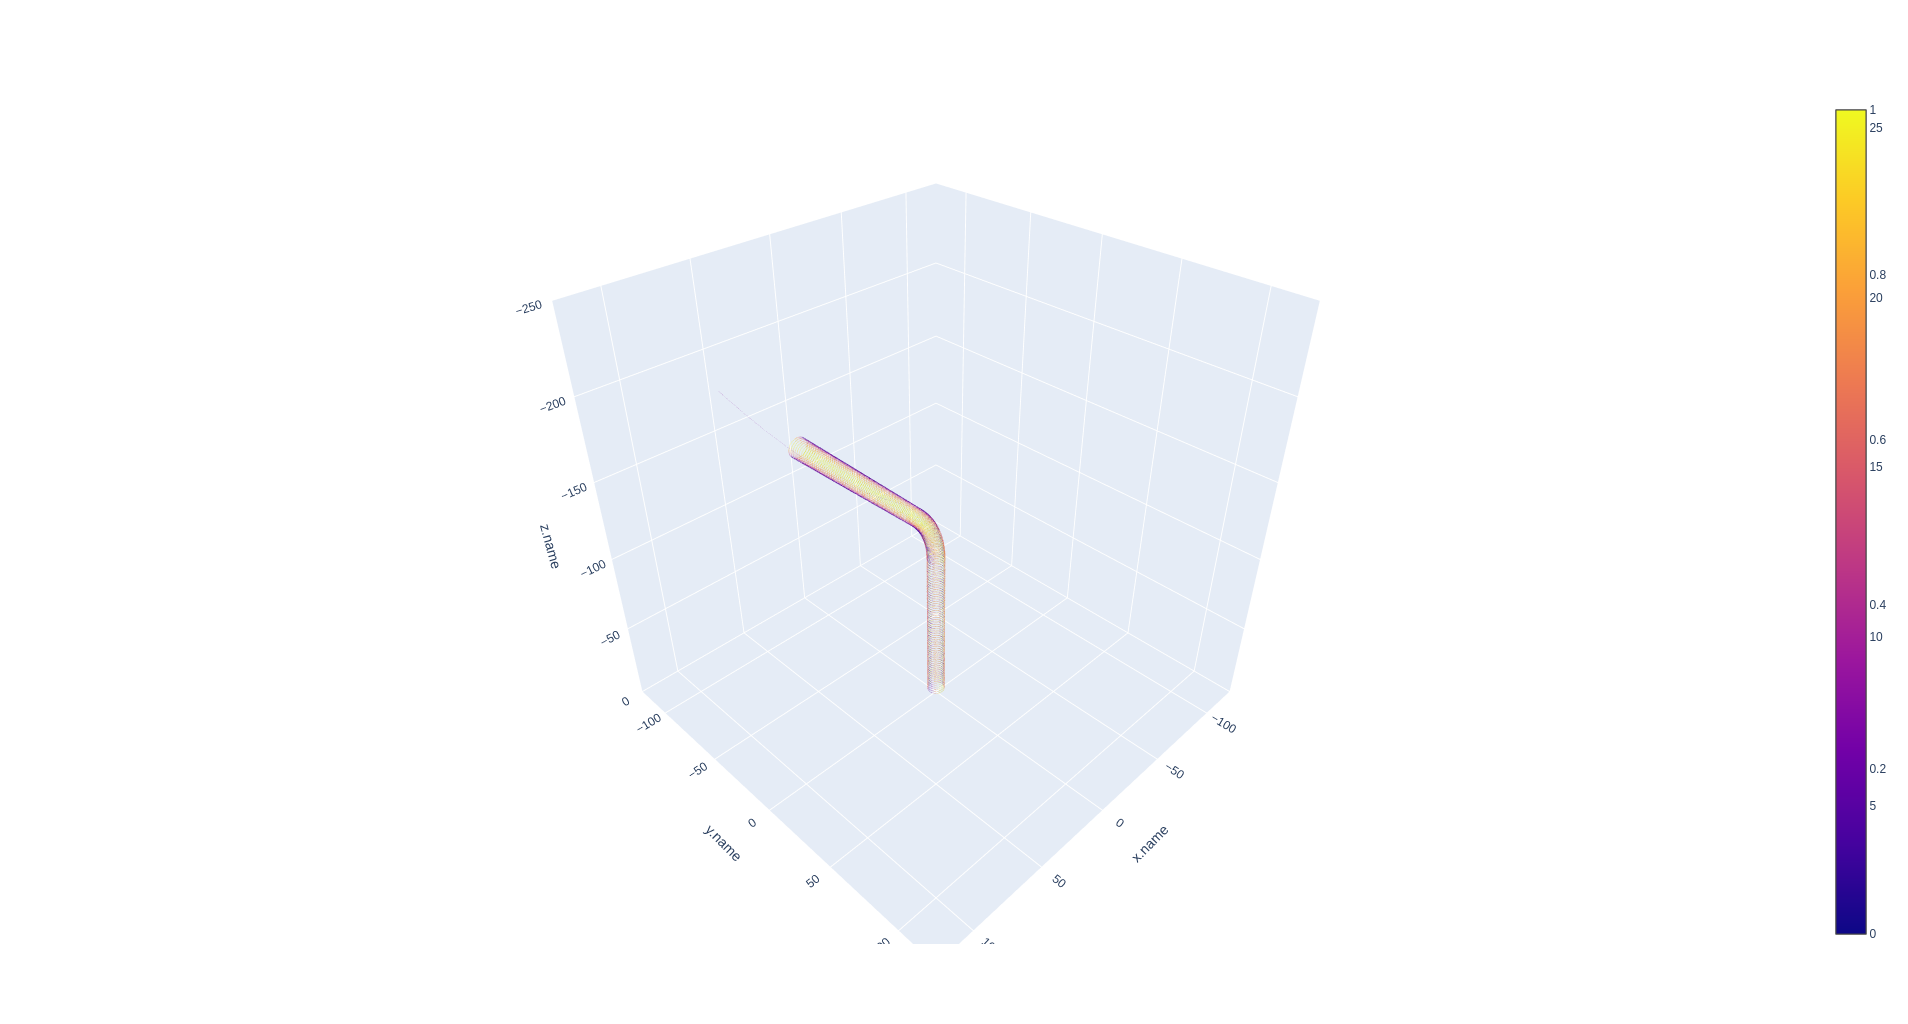

In [23]:
ind = 2
path = x.path[:tn]
d = x.contact[:tn]


fig = go.Figure()


fig.add_trace(go.Cone(x=path[:, 0, 1], y=path[:, 0, 2], z=path[:, 0, 0], 
                             u=path[:, 1, 1], v=path[:, 1, 2], 
                              w=path[:, 1, 0]),
                              #w=-d)
                               )
#fig.add_trace(go.Scatter3d(x=bdry[:, 1], y=bdry[:, 2], z=bdry[:, 0]))

fig.add_trace(go.Cone(x=bdry[:, 1], y=bdry[:, 2], z=bdry[:, 0], 
                             u=tbdry[:, ind, 1], v=tbdry[:, ind, 2], w=tbdry[:, ind, 0]),)


fig.update_layout(
    scene = dict(
        xaxis={'title':'x.name', 'range': [-125, 125]},
        yaxis={'title':'y.name', 'range': [-125, 125]},
        zaxis={'title':'z.name', 'range': [0, -250]},
        aspectmode='cube'),
        width=1024,
        height=1024
)


fig.show()

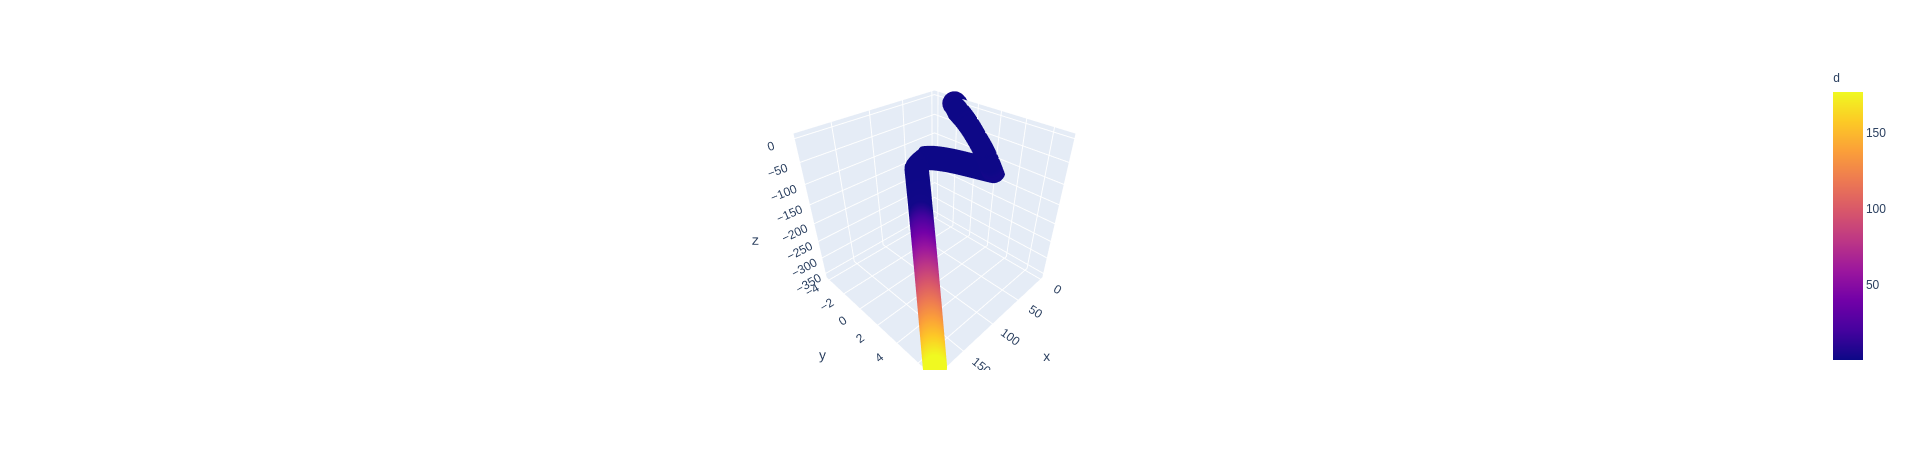

In [24]:
df = pd.DataFrame({'x': path[:, 0, 1], 'y': path[:, 0, 2], 'z': path[:, 0, 0], 'd': d})
fig = px.scatter_3d(df, x='x', y='y', z='z',
              color='d')
fig.show()